# m6A Edit Effects Analysis

This notebook analyzes edit effects on YTH protein binding using the generalized m6A edit pairs dataset.

## Key Experiments:
1. **Context Transfer**: Train on A_vs_A (unmethylated), test on M_vs_M (methylated)
2. **Edit-Aware vs Direct Binding Predictor** comparison
3. **Per-edit-type analysis** across methylation contexts
4. **Edit embedding visualization** (UMAP, t-SNE, PCA)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
import json
import pickle
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not installed, will skip UMAP visualization")

from src.embedding.rna import NucleotideEmbedder

plt.style.use('seaborn-v0_8-whitegrid')
print("Imports complete!")

/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports complete!


## Configuration

In [2]:
# Configuration
DATA_FILE = '../data/rna/m6a/processed/m6a_edit_pairs_dist1_sensitivity_500.csv'
OUTPUT_DIR = Path('../results/m6a/notebook_analysis')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Model parameters
MAX_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
PATIENCE = 15
HIDDEN_DIMS = [256, 128, 64]
EDIT_EMBED_DIM = 32
DEVICE = 'cpu'

# Whether to load saved models or train new ones
LOAD_MODELS = False
SAVE_MODELS = True

print(f"Output directory: {OUTPUT_DIR}")
print(f"Device: {DEVICE}")
print(f"Load models: {LOAD_MODELS}")

Output directory: ../results/m6a/notebook_analysis
Device: cpu
Load models: False


## Load and Prepare Data

In [3]:
def load_data(data_file):
    """Load and prepare the edit pairs data."""
    print(f"Loading data from {data_file}...")
    df = pd.read_csv(data_file)
    
    # Standardize columns
    df['seq_a'] = df['loop_A']
    df['seq_b'] = df['loop_B']
    df['delta_value'] = df['log2_fold_change_median']
    
    # Parse edit position
    def parse_edit_position(x):
        if pd.isna(x):
            return 3
        if isinstance(x, (int, float)):
            return int(x)
        if isinstance(x, str):
            return int(x.split(',')[0]) if x else 3
        return 3
    
    df['edit_position'] = df['edit_positions_str'].apply(parse_edit_position)
    
    # Extract single edit type (X→Y)
    def extract_edit_type(desc):
        if pd.isna(desc):
            return None
        if ':' in desc:
            edit = desc.split(':')[-1]
        else:
            edit = desc
        return edit if '>' in edit else None
    
    df['single_edit'] = df['edit_description'].apply(extract_edit_type)
    
    print(f"  Loaded {len(df):,} pairs")
    return df

df = load_data(DATA_FILE)
print(f"\nPair type distribution:")
print(df['pair_type'].value_counts())
print(f"\nEdit type distribution:")
print(df['single_edit'].value_counts())

Loading data from ../data/rna/m6a/processed/m6a_edit_pairs_dist1_sensitivity_500.csv...


  Loaded 77,824 pairs

Pair type distribution:
pair_type
A_vs_A    36864
M_vs_M    36864
M_vs_A     4096
Name: count, dtype: int64

Edit type distribution:
single_edit
A>C    12288
A>G    12288
A>U    12288
C>G    12288
C>U    12288
G>U    12288
A>M     4096
Name: count, dtype: int64


## Model Definitions

In [4]:
class DirectPredictor(nn.Module):
    """Direct Binding Predictor: f(seq) -> binding, delta = f(B) - f(A)"""
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x).squeeze(-1)
    
    def predict_delta(self, emb_a, emb_b):
        return self.forward(emb_b) - self.forward(emb_a)


class EditAwarePredictor(nn.Module):
    """Edit-Aware Δ Predictor: g(seq_a, edit) -> delta"""
    def __init__(self, seq_dim, edit_dim, hidden_dims, edit_embed_dim):
        super().__init__()
        
        # Edit embedding network
        self.edit_embed = nn.Sequential(
            nn.Linear(edit_dim, edit_embed_dim),
            nn.ReLU(),
            nn.Linear(edit_embed_dim, edit_embed_dim)
        )
        
        # Combined prediction
        combined_dim = seq_dim + edit_embed_dim
        layers = []
        prev_dim = combined_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.predictor = nn.Sequential(*layers)
        
        self.edit_dim = edit_dim
        self.edit_embed_dim = edit_embed_dim
    
    def forward(self, seq_emb, edit_features):
        edit_emb = self.edit_embed(edit_features)
        combined = torch.cat([seq_emb, edit_emb], dim=-1)
        return self.predictor(combined).squeeze(-1)
    
    def get_edit_embedding(self, edit_features):
        return self.edit_embed(edit_features)

print("Model classes defined!")

Model classes defined!


## Helper Functions

In [5]:
def normalize_seq(s):
    """Normalize sequence for embedding."""
    return s.replace('M', 'A').replace('T', 'U')


def create_edit_features(df):
    """Create edit feature vectors."""
    n = len(df)
    
    # Position one-hot (7 positions)
    pos_onehot = np.zeros((n, 7))
    for i, pos in enumerate(df['edit_position'].values):
        if 0 <= pos < 7:
            pos_onehot[i, pos] = 1
    
    # Edit type encoding
    edit_types = {
        'A>C': 0, 'A>G': 1, 'A>U': 2, 'A>M': 3,
        'C>A': 4, 'C>G': 5, 'C>U': 6,
        'G>A': 7, 'G>C': 8, 'G>U': 9,
        'U>A': 10, 'U>C': 11, 'U>G': 12,
        'M>A': 13
    }
    edit_type_onehot = np.zeros((n, len(edit_types)))
    for i, desc in enumerate(df['edit_description'].values):
        if pd.notna(desc):
            edit = desc.split(':')[-1] if ':' in desc else desc
            if edit in edit_types:
                edit_type_onehot[i, edit_types[edit]] = 1
    
    # Pair type encoding
    pair_types = {'A_vs_A': 0, 'M_vs_M': 1, 'M_vs_A': 2}
    pair_type_onehot = np.zeros((n, len(pair_types)))
    for i, pt in enumerate(df['pair_type'].values):
        if pt in pair_types:
            pair_type_onehot[i, pair_types[pt]] = 1
    
    return np.hstack([pos_onehot, edit_type_onehot, pair_type_onehot]).astype(np.float32)


def compute_metrics(y_true, y_pred):
    """Compute comprehensive regression metrics."""
    metrics = {
        'n': len(y_true),
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'r2': r2_score(y_true, y_pred),
    }
    
    try:
        r, p = stats.pearsonr(y_true, y_pred)
        metrics['pearson_r'] = r
        metrics['pearson_p'] = p
    except:
        metrics['pearson_r'] = np.nan
        metrics['pearson_p'] = np.nan
    
    try:
        rho, p = stats.spearmanr(y_true, y_pred)
        metrics['spearman_r'] = rho
        metrics['spearman_p'] = p
    except:
        metrics['spearman_r'] = np.nan
        metrics['spearman_p'] = np.nan
    
    # Direction accuracy
    metrics['direction_accuracy'] = np.mean(np.sign(y_true) == np.sign(y_pred))
    
    return metrics

print("Helper functions defined!")

Helper functions defined!


## Training Functions

In [6]:
def train_direct_predictor(train_emb_a, train_emb_b, train_targets,
                           val_emb_a, val_emb_b, val_targets,
                           max_epochs=100, patience=15, device='cpu'):
    """Train Direct Binding Predictor."""
    input_dim = train_emb_a.shape[1]
    model = DirectPredictor(input_dim, HIDDEN_DIMS).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    train_dataset = TensorDataset(
        torch.FloatTensor(train_emb_a),
        torch.FloatTensor(train_emb_b),
        torch.FloatTensor(train_targets)
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    val_emb_a_t = torch.FloatTensor(val_emb_a).to(device)
    val_emb_b_t = torch.FloatTensor(val_emb_b).to(device)
    val_targets_t = torch.FloatTensor(val_targets).to(device)
    
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for emb_a, emb_b, target in train_loader:
            emb_a, emb_b, target = emb_a.to(device), emb_b.to(device), target.to(device)
            optimizer.zero_grad()
            pred_delta = model.predict_delta(emb_a, emb_b)
            loss = criterion(pred_delta, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        with torch.no_grad():
            val_pred = model.predict_delta(val_emb_a_t, val_emb_b_t)
            val_loss = criterion(val_pred, val_targets_t).item()
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"    Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 20 == 0:
            print(f"    Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    
    model.load_state_dict(best_state)
    return model, history


def train_edit_aware_predictor(train_emb_a, train_edit_features, train_targets,
                               val_emb_a, val_edit_features, val_targets,
                               max_epochs=100, patience=15, device='cpu'):
    """Train Edit-Aware Δ Predictor."""
    input_dim = train_emb_a.shape[1]
    edit_feature_dim = train_edit_features.shape[1]
    
    model = EditAwarePredictor(input_dim, edit_feature_dim, HIDDEN_DIMS, EDIT_EMBED_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    
    train_dataset = TensorDataset(
        torch.FloatTensor(train_emb_a),
        torch.FloatTensor(train_edit_features),
        torch.FloatTensor(train_targets)
    )
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    val_emb_t = torch.FloatTensor(val_emb_a).to(device)
    val_edit_t = torch.FloatTensor(val_edit_features).to(device)
    val_targets_t = torch.FloatTensor(val_targets).to(device)
    
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(max_epochs):
        model.train()
        train_loss = 0
        for seq_emb, edit_feat, target in train_loader:
            seq_emb = seq_emb.to(device)
            edit_feat = edit_feat.to(device)
            target = target.to(device)
            
            optimizer.zero_grad()
            pred = model(seq_emb, edit_feat)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        model.eval()
        with torch.no_grad():
            val_pred = model(val_emb_t, val_edit_t)
            val_loss = criterion(val_pred, val_targets_t).item()
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"    Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 20 == 0:
            print(f"    Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")
    
    model.load_state_dict(best_state)
    return model, history

print("Training functions defined!")

Training functions defined!


## Create Embedder and Compute Embeddings

In [7]:
print("Creating nucleotide embedder...")
embedder = NucleotideEmbedder(
    include_onehot=True,
    include_kmers=True,
    kmer_sizes=[2, 3, 4],
    include_stats=True,
    include_structure=False
)
print(f"Embedding dim: {embedder.embedding_dim}")

# Compute embeddings for all sequences
print("Computing embeddings...")
all_seqs_a = [normalize_seq(s) for s in df['seq_a'].tolist()]
all_seqs_b = [normalize_seq(s) for s in df['seq_b'].tolist()]

all_emb_a = embedder.encode(all_seqs_a)
all_emb_b = embedder.encode(all_seqs_b)
print(f"Embeddings shape: {all_emb_a.shape}")

# Create edit features for all data
all_edit_features = create_edit_features(df)
print(f"Edit features shape: {all_edit_features.shape}")

Creating nucleotide embedder...
Embedding dim: 388
Computing embeddings...


Embeddings shape: (77824, 388)


Edit features shape: (77824, 24)


## Context Transfer Experiment: A_vs_A → M_vs_M

In [8]:
print("="*70)
print("CONTEXT TRANSFER EXPERIMENT: Train on A_vs_A, Test on M_vs_M")
print("="*70)
print("\nHypothesis: Edit effects should transfer across methylation contexts.")
print("Edit-Aware should excel because it explicitly models the edit.")

# Split data by pair type
train_mask = df['pair_type'] == 'A_vs_A'
test_mask = df['pair_type'] == 'M_vs_M'

train_df = df[train_mask].reset_index(drop=True)
test_df = df[test_mask].reset_index(drop=True)

print(f"\nTrain (A_vs_A): {len(train_df):,} pairs")
print(f"Test (M_vs_M): {len(test_df):,} pairs")

# Get corresponding embeddings
train_idx = np.where(train_mask)[0]
test_idx = np.where(test_mask)[0]

train_emb_a = all_emb_a[train_idx]
train_emb_b = all_emb_b[train_idx]
train_edit_features = all_edit_features[train_idx]
train_targets = df.loc[train_mask, 'delta_value'].values

test_emb_a = all_emb_a[test_idx]
test_emb_b = all_emb_b[test_idx]
test_edit_features = all_edit_features[test_idx]
test_targets = df.loc[test_mask, 'delta_value'].values

# Create train/val split
n_train = len(train_df)
indices = np.arange(n_train)
np.random.seed(42)
np.random.shuffle(indices)
val_end = int(n_train * 0.15)
val_idx_local = indices[:val_end]
train_idx_local = indices[val_end:]

print(f"\nTrain subset: {len(train_idx_local):,} pairs")
print(f"Val subset: {len(val_idx_local):,} pairs")

CONTEXT TRANSFER EXPERIMENT: Train on A_vs_A, Test on M_vs_M

Hypothesis: Edit effects should transfer across methylation contexts.
Edit-Aware should excel because it explicitly models the edit.

Train (A_vs_A): 36,864 pairs
Test (M_vs_M): 36,864 pairs

Train subset: 31,335 pairs
Val subset: 5,529 pairs


In [9]:
# Model paths
DIRECT_MODEL_PATH = OUTPUT_DIR / 'direct_model_context_transfer.pt'
EDIT_MODEL_PATH = OUTPUT_DIR / 'edit_model_context_transfer.pt'

if LOAD_MODELS and DIRECT_MODEL_PATH.exists() and EDIT_MODEL_PATH.exists():
    print("Loading saved models...")
    
    # Direct model
    input_dim = train_emb_a.shape[1]
    direct_model = DirectPredictor(input_dim, HIDDEN_DIMS).to(DEVICE)
    direct_model.load_state_dict(torch.load(DIRECT_MODEL_PATH))
    
    # Edit-Aware model
    edit_feature_dim = train_edit_features.shape[1]
    edit_model = EditAwarePredictor(input_dim, edit_feature_dim, HIDDEN_DIMS, EDIT_EMBED_DIM).to(DEVICE)
    edit_model.load_state_dict(torch.load(EDIT_MODEL_PATH))
    
    print("Models loaded!")
else:
    print("Training Direct Binding Predictor...")
    direct_model, direct_history = train_direct_predictor(
        train_emb_a[train_idx_local], train_emb_b[train_idx_local], train_targets[train_idx_local],
        train_emb_a[val_idx_local], train_emb_b[val_idx_local], train_targets[val_idx_local],
        max_epochs=MAX_EPOCHS, patience=PATIENCE, device=DEVICE
    )
    
    print("\nTraining Edit-Aware Δ Predictor...")
    edit_model, edit_history = train_edit_aware_predictor(
        train_emb_a[train_idx_local], train_edit_features[train_idx_local], train_targets[train_idx_local],
        train_emb_a[val_idx_local], train_edit_features[val_idx_local], train_targets[val_idx_local],
        max_epochs=MAX_EPOCHS, patience=PATIENCE, device=DEVICE
    )
    
    if SAVE_MODELS:
        print("\nSaving models...")
        torch.save(direct_model.state_dict(), DIRECT_MODEL_PATH)
        torch.save(edit_model.state_dict(), EDIT_MODEL_PATH)
        print(f"  Saved to {OUTPUT_DIR}")

Training Direct Binding Predictor...


    Epoch 20: train_loss=0.0016, val_loss=0.0005


    Epoch 40: train_loss=0.0013, val_loss=0.0003


    Epoch 60: train_loss=0.0012, val_loss=0.0003


    Epoch 80: train_loss=0.0011, val_loss=0.0002


    Epoch 100: train_loss=0.0010, val_loss=0.0003

Training Edit-Aware Δ Predictor...


    Epoch 20: train_loss=0.0057, val_loss=0.0083


    Epoch 40: train_loss=0.0041, val_loss=0.0073


    Epoch 60: train_loss=0.0034, val_loss=0.0074


    Early stopping at epoch 71

Saving models...
  Saved to ../results/m6a/notebook_analysis


## Evaluate Models and Get Predictions

In [10]:
# Get predictions
direct_model.eval()
edit_model.eval()

with torch.no_grad():
    test_emb_a_t = torch.FloatTensor(test_emb_a).to(DEVICE)
    test_emb_b_t = torch.FloatTensor(test_emb_b).to(DEVICE)
    test_edit_t = torch.FloatTensor(test_edit_features).to(DEVICE)
    
    direct_preds = direct_model.predict_delta(test_emb_a_t, test_emb_b_t).cpu().numpy()
    edit_preds = edit_model(test_emb_a_t, test_edit_t).cpu().numpy()
    
    # Also get edit embeddings for visualization
    edit_embeddings = edit_model.get_edit_embedding(test_edit_t).cpu().numpy()

# Add predictions to test_df for analysis
test_df = test_df.copy()
test_df['direct_pred'] = direct_preds
test_df['edit_pred'] = edit_preds

print("Predictions computed!")
print(f"Direct predictions range: [{direct_preds.min():.3f}, {direct_preds.max():.3f}]")
print(f"Edit-Aware predictions range: [{edit_preds.min():.3f}, {edit_preds.max():.3f}]")
print(f"Actual targets range: [{test_targets.min():.3f}, {test_targets.max():.3f}]")

Predictions computed!
Direct predictions range: [-0.910, 0.726]
Edit-Aware predictions range: [-0.831, 0.856]
Actual targets range: [-0.778, 0.657]


## Overall Performance Metrics

In [11]:
print("="*70)
print("OVERALL PERFORMANCE METRICS (Context Transfer: A_vs_A → M_vs_M)")
print("="*70)

direct_metrics = compute_metrics(test_targets, direct_preds)
edit_metrics = compute_metrics(test_targets, edit_preds)

metrics_df = pd.DataFrame({
    'Metric': ['N', 'MAE', 'MSE', 'RMSE', 'R²', 'Pearson r', 'Pearson p', 
               'Spearman r', 'Spearman p', 'Direction Accuracy'],
    'Direct Binding': [
        direct_metrics['n'],
        f"{direct_metrics['mae']:.4f}",
        f"{direct_metrics['mse']:.4f}",
        f"{direct_metrics['rmse']:.4f}",
        f"{direct_metrics['r2']:.4f}",
        f"{direct_metrics['pearson_r']:.4f}",
        f"{direct_metrics['pearson_p']:.2e}",
        f"{direct_metrics['spearman_r']:.4f}",
        f"{direct_metrics['spearman_p']:.2e}",
        f"{direct_metrics['direction_accuracy']:.4f}"
    ],
    'Edit-Aware Δ': [
        edit_metrics['n'],
        f"{edit_metrics['mae']:.4f}",
        f"{edit_metrics['mse']:.4f}",
        f"{edit_metrics['rmse']:.4f}",
        f"{edit_metrics['r2']:.4f}",
        f"{edit_metrics['pearson_r']:.4f}",
        f"{edit_metrics['pearson_p']:.2e}",
        f"{edit_metrics['spearman_r']:.4f}",
        f"{edit_metrics['spearman_p']:.2e}",
        f"{edit_metrics['direction_accuracy']:.4f}"
    ]
})

display(metrics_df)
metrics_df.to_csv(OUTPUT_DIR / 'overall_metrics.csv', index=False)

OVERALL PERFORMANCE METRICS (Context Transfer: A_vs_A → M_vs_M)


,Metric,Direct Binding,Edit-Aware Δ
0,N,36864,36864
1,MAE,0.1472,0.1379
2,MSE,0.0375,0.0329
3,RMSE,0.1937,0.1815
4,R²,-0.2736,-0.1177
5,Pearson r,0.3629,0.3959
6,Pearson p,0.00e+00,0.00e+00
7,Spearman r,0.3718,0.4085
8,Spearman p,0.00e+00,0.00e+00
9,Direction Accuracy,0.6552,0.6642


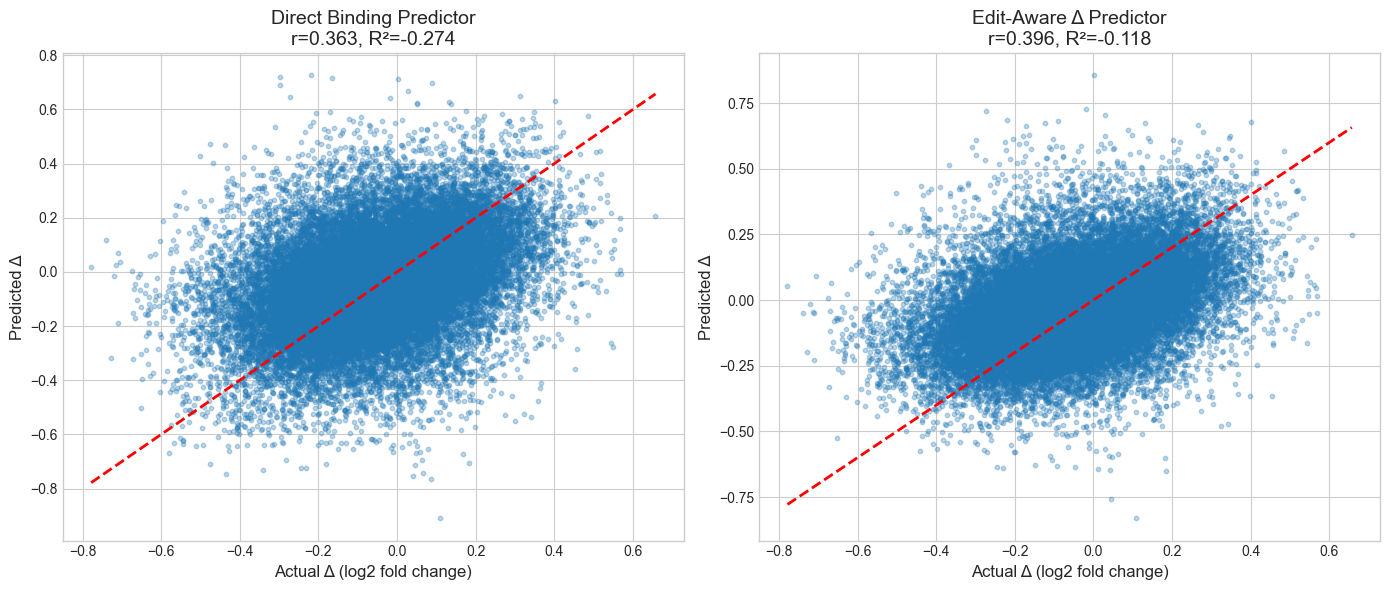

In [12]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Direct model
ax = axes[0]
ax.scatter(test_targets, direct_preds, alpha=0.3, s=10)
ax.plot([test_targets.min(), test_targets.max()], 
        [test_targets.min(), test_targets.max()], 'r--', lw=2)
ax.set_xlabel('Actual Δ (log2 fold change)', fontsize=12)
ax.set_ylabel('Predicted Δ', fontsize=12)
ax.set_title(f'Direct Binding Predictor\nr={direct_metrics["pearson_r"]:.3f}, R²={direct_metrics["r2"]:.3f}', fontsize=14)

# Edit-Aware model
ax = axes[1]
ax.scatter(test_targets, edit_preds, alpha=0.3, s=10)
ax.plot([test_targets.min(), test_targets.max()], 
        [test_targets.min(), test_targets.max()], 'r--', lw=2)
ax.set_xlabel('Actual Δ (log2 fold change)', fontsize=12)
ax.set_ylabel('Predicted Δ', fontsize=12)
ax.set_title(f'Edit-Aware Δ Predictor\nr={edit_metrics["pearson_r"]:.3f}, R²={edit_metrics["r2"]:.3f}', fontsize=14)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prediction_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## Performance Per Edit Type

In [13]:
print("="*70)
print("PERFORMANCE PER EDIT TYPE (M_vs_M test set)")
print("="*70)

per_edit_results = []
edit_types = sorted(test_df['single_edit'].dropna().unique())

for edit_type in edit_types:
    mask = test_df['single_edit'] == edit_type
    if mask.sum() < 10:
        continue
    
    subset = test_df[mask]
    true_vals = subset['delta_value'].values
    direct_vals = subset['direct_pred'].values
    edit_vals = subset['edit_pred'].values
    
    direct_r = stats.pearsonr(true_vals, direct_vals)[0] if len(subset) > 2 else np.nan
    edit_r = stats.pearsonr(true_vals, edit_vals)[0] if len(subset) > 2 else np.nan
    
    per_edit_results.append({
        'Edit': edit_type,
        'Count': len(subset),
        'True Mean Δ': true_vals.mean(),
        'True Std Δ': true_vals.std(),
        'Direct Mean Pred': direct_vals.mean(),
        'Direct MAE': np.abs(true_vals - direct_vals).mean(),
        'Direct r': direct_r,
        'Edit-Aware Mean Pred': edit_vals.mean(),
        'Edit-Aware MAE': np.abs(true_vals - edit_vals).mean(),
        'Edit-Aware r': edit_r
    })

per_edit_df = pd.DataFrame(per_edit_results)
per_edit_df = per_edit_df.sort_values('True Mean Δ', ascending=False)
display(per_edit_df)
per_edit_df.to_csv(OUTPUT_DIR / 'per_edit_performance.csv', index=False)

PERFORMANCE PER EDIT TYPE (M_vs_M test set)


,Edit,Count,True Mean Δ,True Std Δ,Direct Mean Pred,Direct MAE,Direct r,Edit-Aware Mean Pred,Edit-Aware MAE,Edit-Aware r
5,G>U,6144,0.098153,0.145876,0.117969,0.137129,0.226128,0.136371,0.131339,0.265814
0,A>C,6144,0.022542,0.142404,-0.011047,0.155622,0.109673,-0.010553,0.133038,0.162321
2,A>U,6144,-0.046590,0.143555,-0.029855,0.141539,0.088616,-0.018424,0.131495,0.126765
4,C>U,6144,-0.069132,0.144163,-0.018808,0.156126,0.035769,0.000433,0.156191,0.041729
1,A>G,6144,-0.144743,0.151709,-0.147824,0.153803,0.157503,-0.133258,0.140417,0.145825
3,C>G,6144,-0.167285,0.143361,-0.136776,0.139068,0.192940,-0.127868,0.134824,0.155632


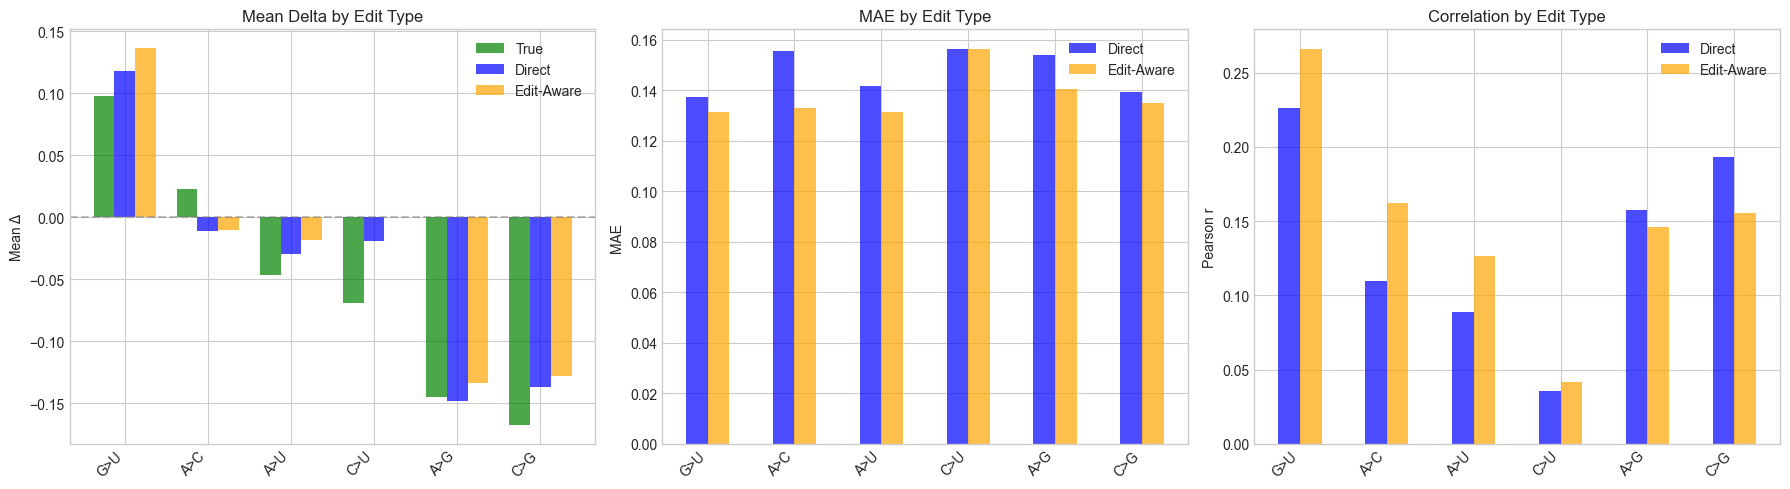

In [14]:
# Visualize per-edit performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean delta by edit type
ax = axes[0]
x = np.arange(len(per_edit_df))
width = 0.25
ax.bar(x - width, per_edit_df['True Mean Δ'], width, label='True', color='green', alpha=0.7)
ax.bar(x, per_edit_df['Direct Mean Pred'], width, label='Direct', color='blue', alpha=0.7)
ax.bar(x + width, per_edit_df['Edit-Aware Mean Pred'], width, label='Edit-Aware', color='orange', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(per_edit_df['Edit'], rotation=45, ha='right')
ax.set_ylabel('Mean Δ')
ax.set_title('Mean Delta by Edit Type')
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# MAE by edit type
ax = axes[1]
ax.bar(x - width/2, per_edit_df['Direct MAE'], width, label='Direct', color='blue', alpha=0.7)
ax.bar(x + width/2, per_edit_df['Edit-Aware MAE'], width, label='Edit-Aware', color='orange', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(per_edit_df['Edit'], rotation=45, ha='right')
ax.set_ylabel('MAE')
ax.set_title('MAE by Edit Type')
ax.legend()

# Pearson r by edit type
ax = axes[2]
ax.bar(x - width/2, per_edit_df['Direct r'], width, label='Direct', color='blue', alpha=0.7)
ax.bar(x + width/2, per_edit_df['Edit-Aware r'], width, label='Edit-Aware', color='orange', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(per_edit_df['Edit'], rotation=45, ha='right')
ax.set_ylabel('Pearson r')
ax.set_title('Correlation by Edit Type')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'per_edit_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## Performance: Methylated (M) vs Unmethylated (A) Context

Compare how well the models predict the same edit types in different contexts.

In [15]:
print("="*70)
print("EDIT EFFECTS: A_vs_A (Unmethylated) vs M_vs_M (Methylated)")
print("="*70)

# Get predictions for A_vs_A as well (using trained models)
train_df_full = df[df['pair_type'] == 'A_vs_A'].copy()
train_emb_a_full = all_emb_a[train_mask]
train_emb_b_full = all_emb_b[train_mask]
train_edit_full = all_edit_features[train_mask]

with torch.no_grad():
    train_emb_a_t = torch.FloatTensor(train_emb_a_full).to(DEVICE)
    train_emb_b_t = torch.FloatTensor(train_emb_b_full).to(DEVICE)
    train_edit_t = torch.FloatTensor(train_edit_full).to(DEVICE)
    
    train_direct_preds = direct_model.predict_delta(train_emb_a_t, train_emb_b_t).cpu().numpy()
    train_edit_preds = edit_model(train_emb_a_t, train_edit_t).cpu().numpy()

train_df_full['direct_pred'] = train_direct_preds
train_df_full['edit_pred'] = train_edit_preds

# Compare edit effects in A vs M context
context_comparison = []
common_edits = set(train_df_full['single_edit'].dropna().unique()) & set(test_df['single_edit'].dropna().unique())

for edit_type in sorted(common_edits):
    # A context (unmethylated)
    a_mask = train_df_full['single_edit'] == edit_type
    a_subset = train_df_full[a_mask]
    
    # M context (methylated)
    m_mask = test_df['single_edit'] == edit_type
    m_subset = test_df[m_mask]
    
    if len(a_subset) < 10 or len(m_subset) < 10:
        continue
    
    context_comparison.append({
        'Edit': edit_type,
        'A_count': len(a_subset),
        'A_true_mean': a_subset['delta_value'].mean(),
        'A_true_std': a_subset['delta_value'].std(),
        'M_count': len(m_subset),
        'M_true_mean': m_subset['delta_value'].mean(),
        'M_true_std': m_subset['delta_value'].std(),
        'Delta_effect': m_subset['delta_value'].mean() - a_subset['delta_value'].mean(),
        'A_direct_r': stats.pearsonr(a_subset['delta_value'], a_subset['direct_pred'])[0],
        'M_direct_r': stats.pearsonr(m_subset['delta_value'], m_subset['direct_pred'])[0],
        'A_edit_r': stats.pearsonr(a_subset['delta_value'], a_subset['edit_pred'])[0],
        'M_edit_r': stats.pearsonr(m_subset['delta_value'], m_subset['edit_pred'])[0],
    })

context_df = pd.DataFrame(context_comparison)
context_df = context_df.sort_values('A_true_mean', ascending=False)
display(context_df)
context_df.to_csv(OUTPUT_DIR / 'context_comparison.csv', index=False)

EDIT EFFECTS: A_vs_A (Unmethylated) vs M_vs_M (Methylated)


,Edit,A_count,A_true_mean,A_true_std,M_count,M_true_mean,M_true_std,Delta_effect,A_direct_r,M_direct_r,A_edit_r,M_edit_r
5,G>U,6144,0.128355,0.145506,6144,0.098153,0.145888,-0.030202,0.995602,0.226128,0.941183,0.265814
0,A>C,6144,-0.011462,0.169682,6144,0.022542,0.142416,0.034005,0.997092,0.109673,0.952993,0.162321
4,C>U,6144,-0.020687,0.152992,6144,-0.069132,0.144175,-0.048445,0.996696,0.035769,0.950410,0.041729
2,A>U,6144,-0.032150,0.138585,6144,-0.046590,0.143567,-0.014440,0.995867,0.088616,0.932896,0.126765
3,C>G,6144,-0.149042,0.150890,6144,-0.167285,0.143373,-0.018243,0.995643,0.192940,0.943967,0.155632
1,A>G,6144,-0.160505,0.167576,6144,-0.144743,0.151722,0.015762,0.996458,0.157503,0.955171,0.145825


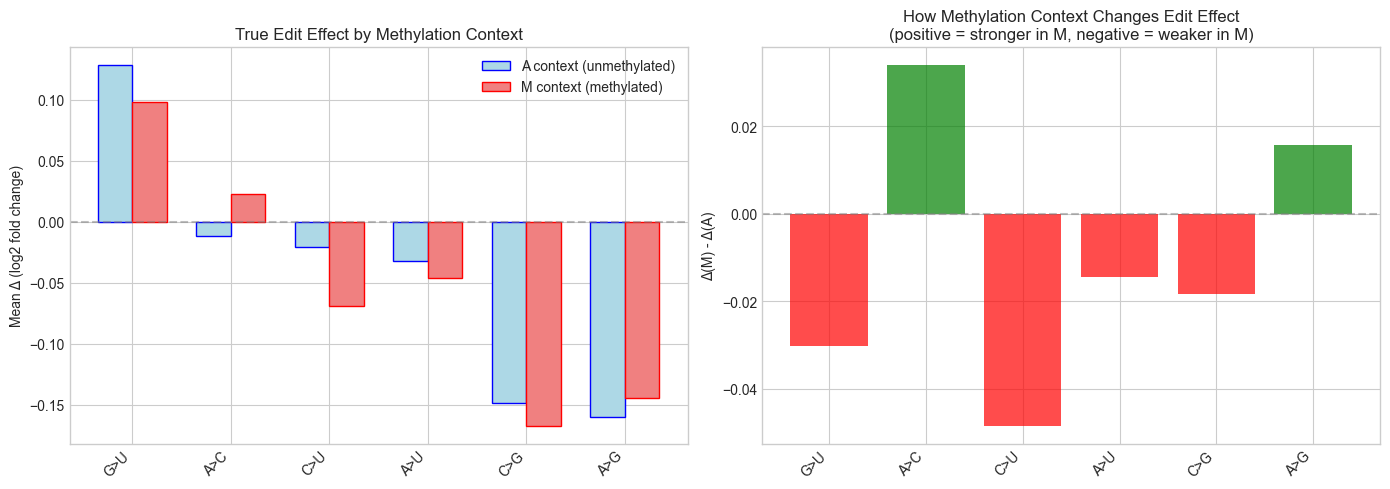

In [16]:
# Visualize context comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# True effect in A vs M context
ax = axes[0]
x = np.arange(len(context_df))
width = 0.35
ax.bar(x - width/2, context_df['A_true_mean'], width, label='A context (unmethylated)', 
       color='lightblue', edgecolor='blue')
ax.bar(x + width/2, context_df['M_true_mean'], width, label='M context (methylated)', 
       color='lightcoral', edgecolor='red')
ax.set_xticks(x)
ax.set_xticklabels(context_df['Edit'], rotation=45, ha='right')
ax.set_ylabel('Mean Δ (log2 fold change)')
ax.set_title('True Edit Effect by Methylation Context')
ax.legend()
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

# Delta effect (M - A)
ax = axes[1]
colors = ['red' if x < 0 else 'green' for x in context_df['Delta_effect']]
ax.bar(x, context_df['Delta_effect'], color=colors, alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(context_df['Edit'], rotation=45, ha='right')
ax.set_ylabel('Δ(M) - Δ(A)')
ax.set_title('How Methylation Context Changes Edit Effect\n(positive = stronger in M, negative = weaker in M)')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'context_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Edit Embedding Visualization (UMAP, t-SNE, PCA)

Analyze if the learned edit embeddings capture meaningful semantic structure.

In [17]:
print("="*70)
print("EDIT EMBEDDING VISUALIZATION")
print("="*70)

# Get edit embeddings for test set
print(f"Edit embeddings shape: {edit_embeddings.shape}")

# Prepare labels for coloring
edit_types_test = test_df['single_edit'].values
positions_test = test_df['edit_position'].values
deltas_test = test_df['delta_value'].values

# Sample for visualization (too many points otherwise)
np.random.seed(42)
sample_size = min(5000, len(edit_embeddings))
sample_idx = np.random.choice(len(edit_embeddings), sample_size, replace=False)

emb_sample = edit_embeddings[sample_idx]
edit_types_sample = edit_types_test[sample_idx]
positions_sample = positions_test[sample_idx]
deltas_sample = deltas_test[sample_idx]

EDIT EMBEDDING VISUALIZATION
Edit embeddings shape: (36864, 32)


In [18]:
# PCA
print("Computing PCA...")
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb_sample)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# t-SNE (use max_iter for newer sklearn versions)
print("Computing t-SNE...")
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
except TypeError:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
emb_tsne = tsne.fit_transform(emb_sample)

# UMAP
if HAS_UMAP:
    print("Computing UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    emb_umap = reducer.fit_transform(emb_sample)
else:
    emb_umap = None

Computing PCA...
PCA explained variance: 47.95%
Computing t-SNE...


Computing UMAP...


/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


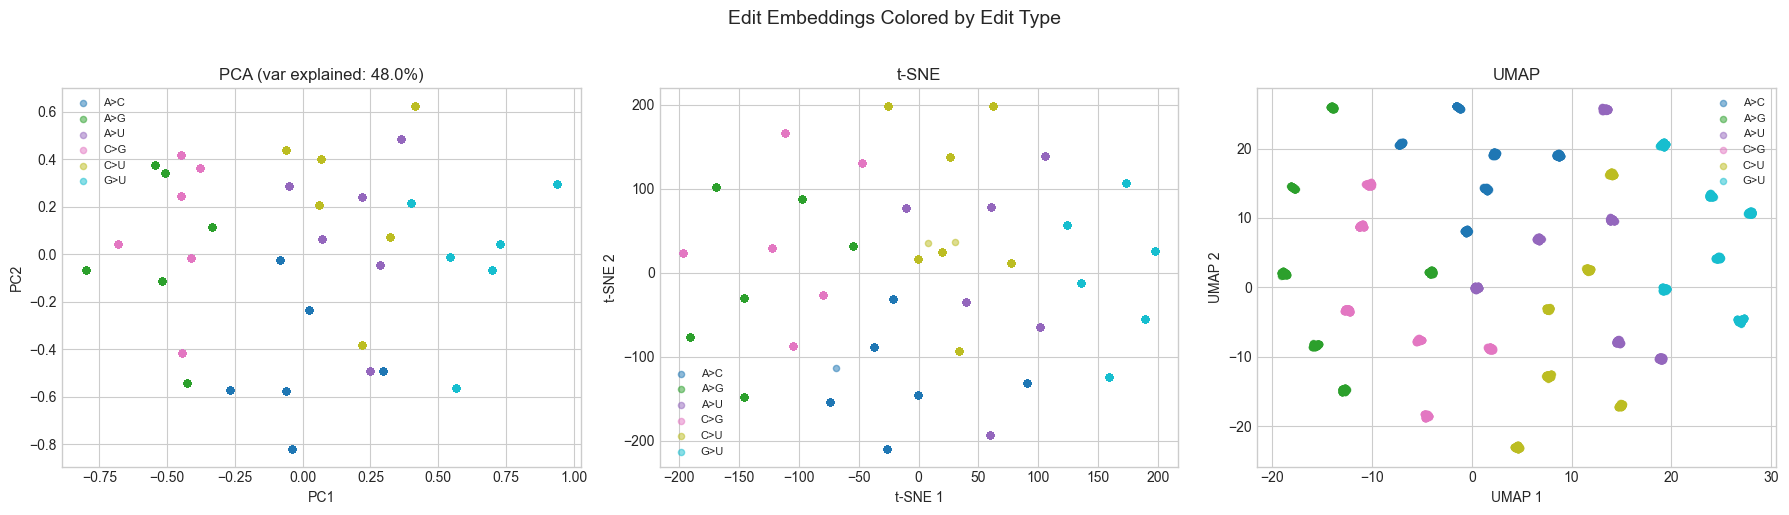

In [19]:
# Visualization by Edit Type
n_plots = 3 if HAS_UMAP else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

# Create color map for edit types
unique_edits = sorted(set(edit_types_sample) - {None})
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_edits)))
edit_to_color = {e: c for e, c in zip(unique_edits, colors)}

# PCA
ax = axes[0]
for edit_type in unique_edits:
    mask = edit_types_sample == edit_type
    ax.scatter(emb_pca[mask, 0], emb_pca[mask, 1], 
               c=[edit_to_color[edit_type]], label=edit_type, alpha=0.5, s=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title(f'PCA (var explained: {pca.explained_variance_ratio_.sum():.1%})')
ax.legend(loc='best', fontsize=8)

# t-SNE
ax = axes[1]
for edit_type in unique_edits:
    mask = edit_types_sample == edit_type
    ax.scatter(emb_tsne[mask, 0], emb_tsne[mask, 1], 
               c=[edit_to_color[edit_type]], label=edit_type, alpha=0.5, s=20)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE')
ax.legend(loc='best', fontsize=8)

# UMAP
if HAS_UMAP:
    ax = axes[2]
    for edit_type in unique_edits:
        mask = edit_types_sample == edit_type
        ax.scatter(emb_umap[mask, 0], emb_umap[mask, 1], 
                   c=[edit_to_color[edit_type]], label=edit_type, alpha=0.5, s=20)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP')
    ax.legend(loc='best', fontsize=8)

plt.suptitle('Edit Embeddings Colored by Edit Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'edit_embeddings_by_type.png', dpi=150, bbox_inches='tight')
plt.show()

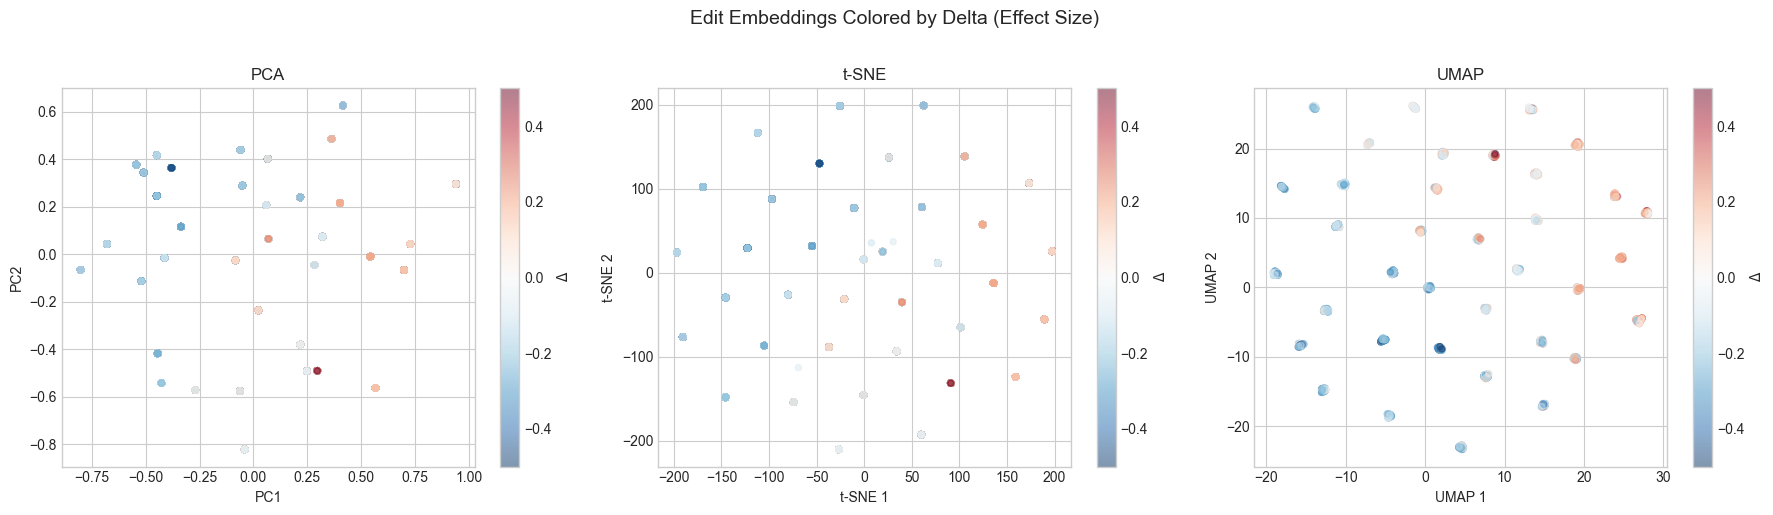

In [20]:
# Visualization by Delta Value (effect size)
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

# PCA
ax = axes[0]
scatter = ax.scatter(emb_pca[:, 0], emb_pca[:, 1], c=deltas_sample, 
                     cmap='RdBu_r', alpha=0.5, s=20, vmin=-0.5, vmax=0.5)
plt.colorbar(scatter, ax=ax, label='Δ')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA')

# t-SNE
ax = axes[1]
scatter = ax.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=deltas_sample, 
                     cmap='RdBu_r', alpha=0.5, s=20, vmin=-0.5, vmax=0.5)
plt.colorbar(scatter, ax=ax, label='Δ')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE')

# UMAP
if HAS_UMAP:
    ax = axes[2]
    scatter = ax.scatter(emb_umap[:, 0], emb_umap[:, 1], c=deltas_sample, 
                         cmap='RdBu_r', alpha=0.5, s=20, vmin=-0.5, vmax=0.5)
    plt.colorbar(scatter, ax=ax, label='Δ')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP')

plt.suptitle('Edit Embeddings Colored by Delta (Effect Size)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'edit_embeddings_by_delta.png', dpi=150, bbox_inches='tight')
plt.show()

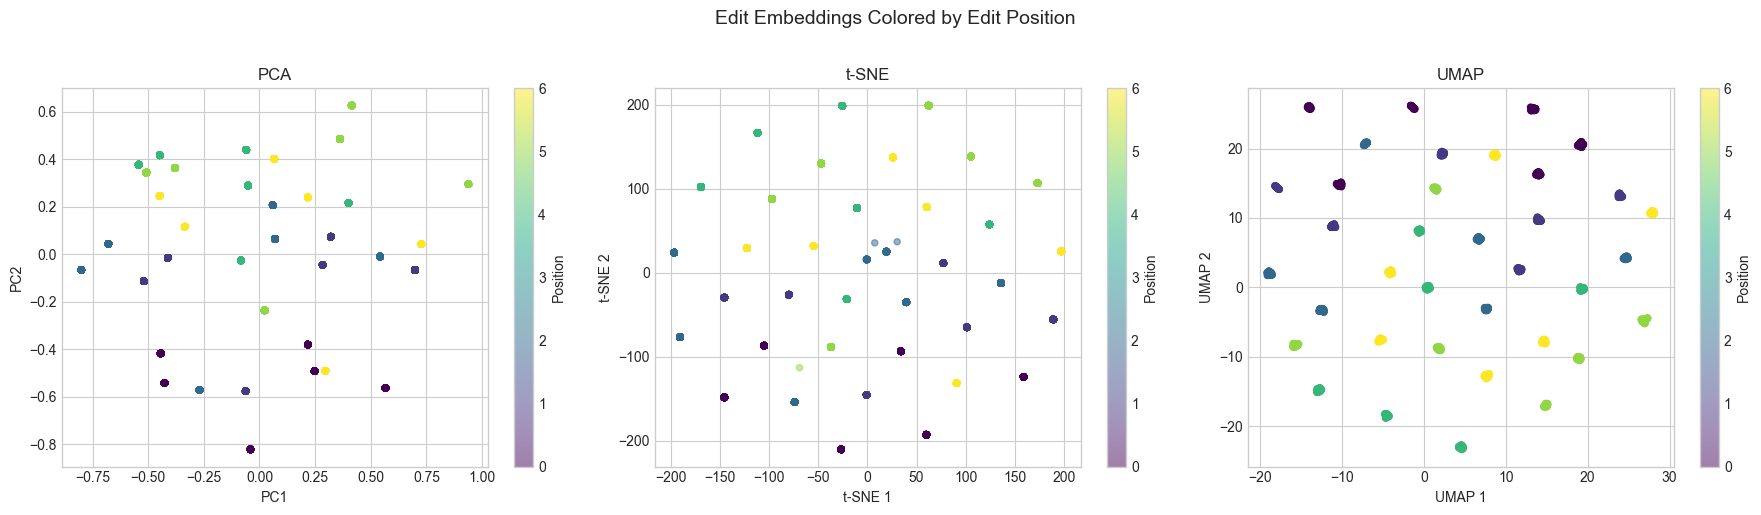

In [21]:
# Visualization by Position
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

# PCA
ax = axes[0]
scatter = ax.scatter(emb_pca[:, 0], emb_pca[:, 1], c=positions_sample, 
                     cmap='viridis', alpha=0.5, s=20)
plt.colorbar(scatter, ax=ax, label='Position')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA')

# t-SNE
ax = axes[1]
scatter = ax.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=positions_sample, 
                     cmap='viridis', alpha=0.5, s=20)
plt.colorbar(scatter, ax=ax, label='Position')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('t-SNE')

# UMAP
if HAS_UMAP:
    ax = axes[2]
    scatter = ax.scatter(emb_umap[:, 0], emb_umap[:, 1], c=positions_sample, 
                         cmap='viridis', alpha=0.5, s=20)
    plt.colorbar(scatter, ax=ax, label='Position')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP')

plt.suptitle('Edit Embeddings Colored by Edit Position', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'edit_embeddings_by_position.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary and Key Findings

In [22]:
print("="*70)
print("SUMMARY: KEY FINDINGS")
print("="*70)

print("\n1. CONTEXT TRANSFER (A_vs_A → M_vs_M):")
print(f"   - Direct Binding Predictor: r = {direct_metrics['pearson_r']:.4f}")
print(f"   - Edit-Aware Δ Predictor:  r = {edit_metrics['pearson_r']:.4f}")
winner = "Edit-Aware" if edit_metrics['pearson_r'] > direct_metrics['pearson_r'] else "Direct"
print(f"   - Winner: {winner}")

print("\n2. EDIT TYPE EFFECTS (sorted by mean Δ):")
for _, row in per_edit_df.head(7).iterrows():
    print(f"   - {row['Edit']}: Mean Δ = {row['True Mean Δ']:+.4f} (n={row['Count']})")

print("\n3. CONTEXT EFFECT (How methylation changes edit effects):")
for _, row in context_df.iterrows():
    print(f"   - {row['Edit']}: Δ(M) - Δ(A) = {row['Delta_effect']:+.4f}")

print("\n4. OUTPUT FILES:")
for f in OUTPUT_DIR.glob('*'):
    print(f"   - {f.name}")

SUMMARY: KEY FINDINGS

1. CONTEXT TRANSFER (A_vs_A → M_vs_M):
   - Direct Binding Predictor: r = 0.3629
   - Edit-Aware Δ Predictor:  r = 0.3959
   - Winner: Edit-Aware

2. EDIT TYPE EFFECTS (sorted by mean Δ):
   - G>U: Mean Δ = +0.0982 (n=6144)
   - A>C: Mean Δ = +0.0225 (n=6144)
   - A>U: Mean Δ = -0.0466 (n=6144)
   - C>U: Mean Δ = -0.0691 (n=6144)
   - A>G: Mean Δ = -0.1447 (n=6144)
   - C>G: Mean Δ = -0.1673 (n=6144)

3. CONTEXT EFFECT (How methylation changes edit effects):
   - G>U: Δ(M) - Δ(A) = -0.0302
   - A>C: Δ(M) - Δ(A) = +0.0340
   - C>U: Δ(M) - Δ(A) = -0.0484
   - A>U: Δ(M) - Δ(A) = -0.0144
   - C>G: Δ(M) - Δ(A) = -0.0182
   - A>G: Δ(M) - Δ(A) = +0.0158

4. OUTPUT FILES:
   - context_comparison.png
   - direct_model_context_transfer.pt
   - edit_embeddings_by_type.png
   - per_edit_performance.png
   - overall_metrics.csv
   - edit_embeddings_by_delta.png
   - prediction_scatter.png
   - edit_embeddings_by_position.png
   - edit_model_context_transfer.pt
   - context_co

In [23]:
# Save all results to JSON
results = {
    'overall_metrics': {
        'direct': {k: float(v) if isinstance(v, (np.floating, float)) else v 
                   for k, v in direct_metrics.items()},
        'edit_aware': {k: float(v) if isinstance(v, (np.floating, float)) else v 
                       for k, v in edit_metrics.items()}
    },
    'per_edit': per_edit_df.to_dict('records'),
    'context_comparison': context_df.to_dict('records')
}

with open(OUTPUT_DIR / 'all_results.json', 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"\nAll results saved to {OUTPUT_DIR / 'all_results.json'}")


All results saved to ../results/m6a/notebook_analysis/all_results.json
